In [1]:
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
import scipy.optimize as opt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

In [2]:
def LIMA(alpha, Non, Noff):
    sig = np.sqrt(2) * np.sqrt(
        Non * np.log((1 + alpha) / alpha * (Non / (Non + Noff)))
        + Noff * np.log((1 + alpha) * Noff / (Non + Noff))
    )
    if type(sig) is np.ndarray:
        sig[np.where((Non - Noff * alpha) < 0)] = -sig[
            np.where((Non - Noff * alpha) < 0)
        ]
    else:
        if (Non - Noff * alpha) < 0:
            sig = -sig
    return sig

In [3]:
J1857 = np.load("/home2/hky/github/Gamma_Energy/Exptdata/mergedData_J1857_eqzenith.npz")

In [5]:
J1857={key:J1857[key] for key in J1857}

In [7]:
predictor_energy = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/log10Energy"
)
J1857_df = pd.DataFrame(J1857)
J1857_df["sumpf"] = np.log10(J1857["sumpf"])
J1857["energy"] = 10**predictor_energy.predict(J1857_df).to_numpy()

In [8]:
J1857["isgamma"] = np.where(((J1857["Ra"] > 284) & (J1857["Ra"] < 285)), 1, 0)


In [9]:
alist = list()
blist = list()
sigma10list = list()
sigma20list = list()
sigma50list = list()
sigma100list = list()
for a in np.logspace(-5, -1, 41):
    for b in np.linspace(0, 4, 41):
        sig = np.zeros(4)
        for i, energymin in enumerate([10,20,50,100]):
            cuted = np.where(
                (
                    (J1857["summd"] < a  * J1857["sumpf"] ** b)
                    | (J1857["summd"] < 0.4)
                )
                & (J1857["energy"] > energymin)
            )
            sig[i] = LIMA(
                1 / 359,
                np.sum(J1857["isgamma"][cuted] == 1),
                np.sum(J1857["isgamma"][cuted] == 0),
            )
        alist.append(a)
        blist.append(b)
        sigma10list.append(sig[0])
        sigma20list.append(sig[1])
        sigma50list.append(sig[2])
        sigma100list.append(sig[3])
        print(
            f"{a:.1e}",
            f"{b:.1f}",
            f"{sig[0]:.2f}",
            f"{sig[1]:.2f}",
            f"{sig[2]:.2f}",
            f"{sig[3]:.2f}",
        )


1.0e-05 0.0 4.19 2.88 1.84 -0.17
1.0e-05 0.1 4.19 2.88 1.84 -0.17
1.0e-05 0.2 4.19 2.88 1.84 -0.17
1.0e-05 0.3 4.19 2.88 1.84 -0.17
1.0e-05 0.4 4.19 2.88 1.84 -0.17
1.0e-05 0.5 4.19 2.88 1.84 -0.17
1.0e-05 0.6 4.19 2.88 1.84 -0.17
1.0e-05 0.7 4.19 2.88 1.84 -0.17
1.0e-05 0.8 4.19 2.88 1.84 -0.17
1.0e-05 0.9 4.19 2.88 1.84 -0.17
1.0e-05 1.0 4.19 2.88 1.84 -0.17
1.0e-05 1.1 4.19 2.88 1.84 -0.17
1.0e-05 1.2 4.19 2.88 1.84 -0.17
1.0e-05 1.3 4.19 2.88 1.84 -0.17
1.0e-05 1.4 4.19 2.88 1.84 -0.17
1.0e-05 1.5 4.19 2.88 1.84 -0.17
1.0e-05 1.6 4.19 2.87 1.83 -0.19
1.0e-05 1.7 4.22 2.92 1.95 0.18
1.0e-05 1.8 4.28 3.00 1.89 -0.05
1.0e-05 1.9 4.37 3.13 2.01 -0.10
1.0e-05 2.0 4.34 3.08 1.58 0.62
1.0e-05 2.1 4.56 3.46 2.10 1.83
1.0e-05 2.2 3.65 2.84 1.61 1.59
1.0e-05 2.3 4.01 3.52 2.03 2.07
1.0e-05 2.4 4.20 3.59 2.26 2.36
1.0e-05 2.5 3.34 2.86 1.83 2.27
1.0e-05 2.6 2.91 2.47 0.97 1.63
1.0e-05 2.7 1.21 1.04 0.12 0.93
1.0e-05 2.8 1.80 1.26 0.04 1.16
1.0e-05 2.9 1.80 1.49 -0.18 1.11
1.0e-05 3.0 1.85 1.7

In [12]:
alist = np.array(alist)
blist = np.array(blist)
sigma10list = np.array(sigma10list)
sigma20list = np.array(sigma20list)
sigma50list = np.array(sigma50list)
sigma100list = np.array(sigma100list)
b,a = np.meshgrid(np.linspace(0, 4, 41),np.logspace(-5, -1, 41))

In [34]:
np.save("./sigma100list.npy",sigma100list)

In [23]:
np.argmax(sigma10list)

754

In [25]:
np.log10(alist[np.argmax(sigma10list)])

-3.2

In [28]:
alist[np.argmax(sigma10list)]

0.000630957344480193

In [27]:
blist[np.argmax(sigma10list)]

1.6

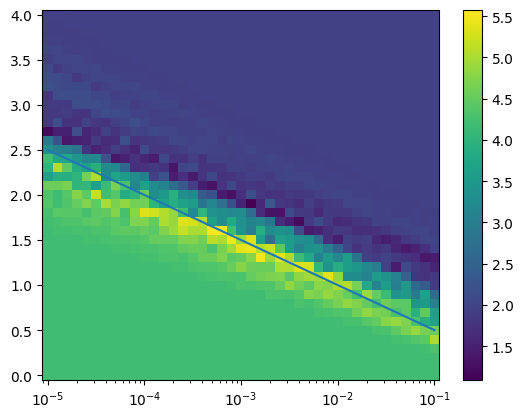

In [19]:
cs=plt.pcolormesh(a, b, sigma10list.reshape(a.shape))
plt.colorbar()
x = np.logspace(-5, -1, 41)
y = -np.log10(x)/2
plt.plot(x,y)
plt.xscale("log")
# plt.clabel(cs,inline=True)
plt.show()

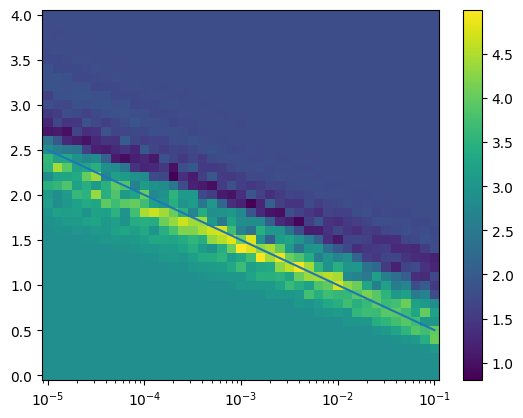

In [20]:
cs=plt.pcolormesh(a, b, sigma20list.reshape(a.shape))
plt.colorbar()
x = np.logspace(-5, -1, 41)
y = -np.log10(x)/2
plt.plot(x,y)
plt.xscale("log")
# plt.clabel(cs,inline=True)
plt.show()

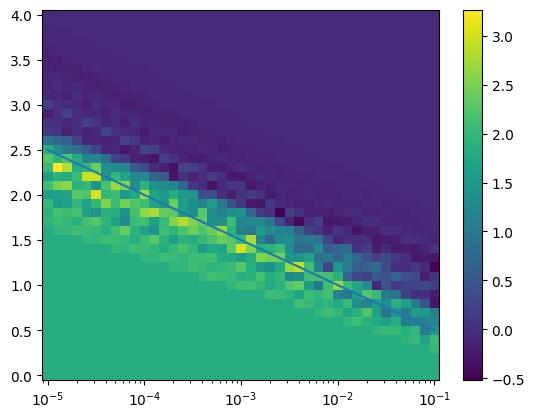

In [21]:
cs=plt.pcolormesh(a, b, sigma50list.reshape(a.shape))
plt.colorbar()
x = np.logspace(-5, -1, 41)
y = -np.log10(x)/2
plt.plot(x,y)
plt.xscale("log")
# plt.clabel(cs,inline=True)
plt.show()

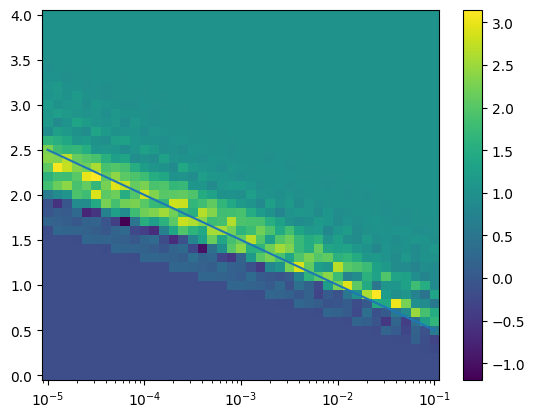

In [22]:
cs=plt.pcolormesh(a, b, sigma100list.reshape(a.shape))
plt.colorbar()
x = np.logspace(-5, -1, 41)
y = -np.log10(x)/2
plt.plot(x,y)
plt.xscale("log")
# plt.clabel(cs,inline=True)
plt.show()

In [3]:
Crab = np.load("/home2/hky/github/Gamma_Energy/Exptdata/mergedData_eqzenith_mdcut.npz")

In [4]:
Crabcut=np.where((Crab["Dec"]<22.5)&(Crab["Dec"]>21.5)&((Crab["summd"]<5e-3*Crab["sumpf"]**1.2)|(Crab["summd"]<0.4)))
# Crabcut=np.where(((Crab["summd"]<5.1e1*Crab["sumpf"]**1.2)|(Crab["summd"]<0.4)))
Crabdata={key:Crab[key][Crabcut] for key in Crab}

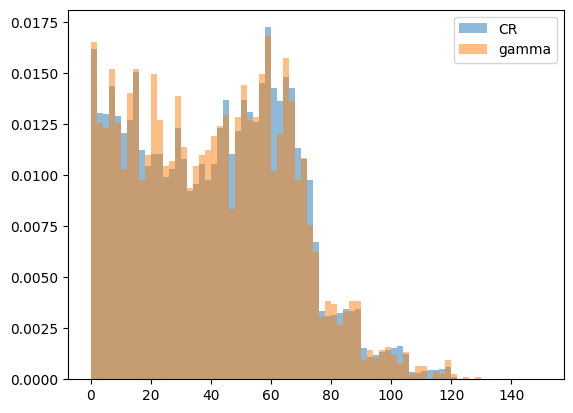

In [63]:
abscx_bins = np.linspace(0,150,76)
plt.hist(np.abs(Crabdata["cx"][Crabdata["isgamma"] == 0]),bins=abscx_bins,label="CR",alpha=0.5,density=True)
plt.hist(np.abs(Crabdata["cx"][Crabdata["isgamma"] == 1]),bins=abscx_bins,label="gamma",alpha=0.5,density=True)
plt.legend()
plt.show()

In [ ]:
np.sum(Crabdata["isgamma"]==1)

34668

In [ ]:
np.sum(Crabdata["isgamma"]==0)

11568288

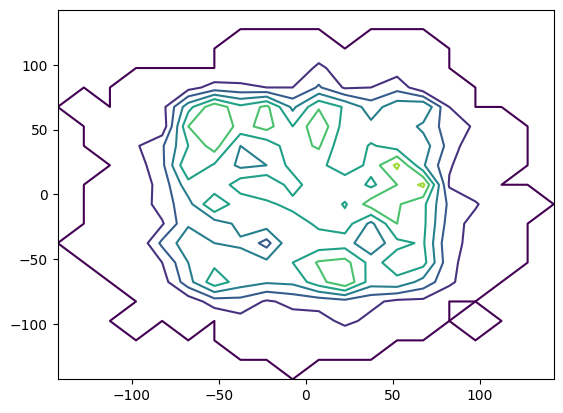

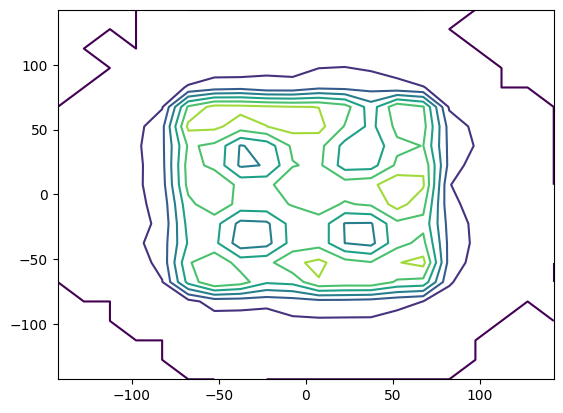

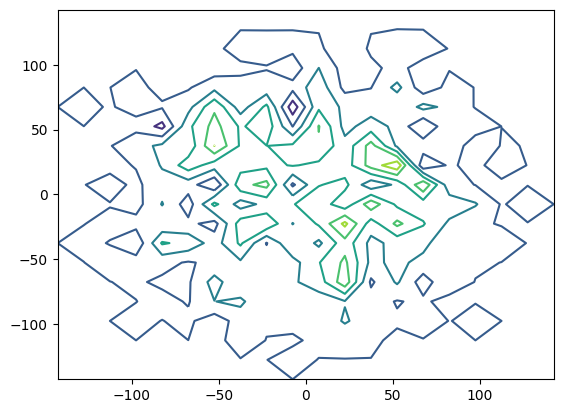

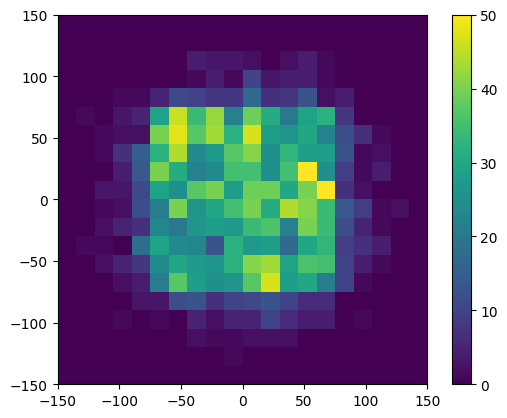

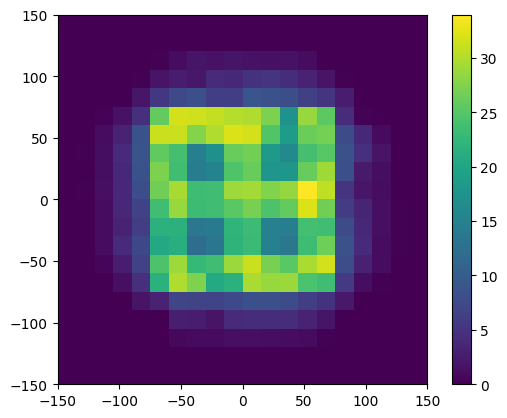

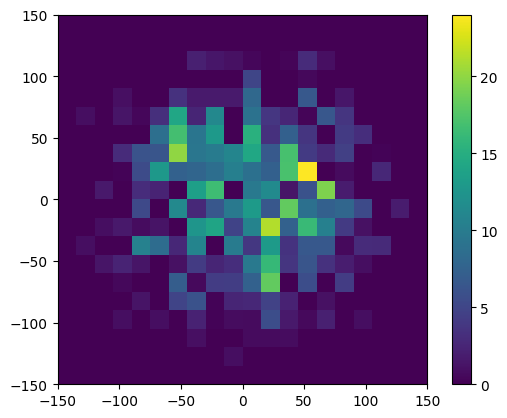

In [12]:
cx_bins = np.linspace(-150, 150, 21)
cy_bins = np.linspace(-150, 150, 21)
H_nearCrab, xedges, yedges = np.histogram2d(
    Crabdata["cx"][Crabdata["isgamma"] == 1],
    Crabdata["cy"][Crabdata["isgamma"] == 1],
    bins=(cx_bins, cy_bins),
    # density=True,
)
H_notnearCrab, xedges, yedges = np.histogram2d(
    Crabdata["cx"][Crabdata["isgamma"] == 0],
    Crabdata["cy"][Crabdata["isgamma"] == 0],
    bins=(cx_bins, cy_bins),
    # density=True,
)
H_nearCrab = H_nearCrab.T
H_notnearCrab = H_notnearCrab.T
H_notnearCrab/=359
xcenter = (xedges[:-1] + xedges[1:]) / 2
ycenter = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(xcenter, ycenter)
plt.contour(X, Y, H_nearCrab)
plt.show()
plt.contour(X, Y, H_notnearCrab)
plt.show()
plt.contour(X, Y, H_nearCrab - H_notnearCrab)
plt.show()
plt.imshow(
    H_nearCrab,
    interpolation="nearest",
    origin="lower",
    extent=[cx_bins[0], cx_bins[-1], cy_bins[0], cy_bins[-1]],
)
plt.colorbar()
plt.show()
plt.imshow(
    H_notnearCrab,
    interpolation="nearest",
    origin="lower",
    extent=[cx_bins[0], cx_bins[-1], cy_bins[0], cy_bins[-1]],
)
plt.colorbar()
plt.show()
delta = H_nearCrab - H_notnearCrab
delta[delta<0]=0
plt.imshow(
    delta,
    interpolation="nearest",
    origin="lower",
    extent=[cx_bins[0], cx_bins[-1], cy_bins[0], cy_bins[-1]],
    
)
plt.colorbar()
plt.show()


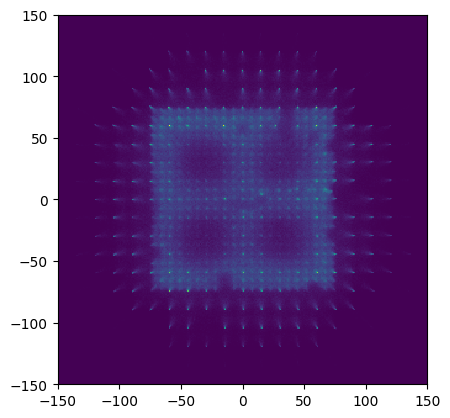

In [21]:
cx_bins = np.linspace(-150,150,301)
cy_bins = np.linspace(-150,150,301)
H_nearCrab,_,_ = np.histogram2d(Crabdata["cx"], Crabdata["cy"], bins=(cx_bins, cy_bins),density=True)
H_nearCrab = H_nearCrab.T
plt.imshow(H_nearCrab, interpolation='nearest', origin='lower',
        extent=[cx_bins[0], cx_bins[-1], cy_bins[0], cy_bins[-1]])

In [5]:
predictor_energy = TabularPredictor.load(
    "/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_ifcut=0/log10Energy"
)
Crabdata_df = pd.DataFrame(Crabdata)
Crabdata_df["sumpf"] = np.log10(Crabdata_df["sumpf"])
Crabdata["energy"] = 10**predictor_energy.predict(Crabdata_df).to_numpy()

In [6]:
def getmaxab(sig, a, b, amax, bmax, sigmax):
    need = np.where(sig > sigmax)
    sigmax[need] = sig[need]
    amax[need] = a
    bmax[need] = b


In [47]:
np.log10(np.min(Crabdata["sumpf"]))

1.5430547286610514

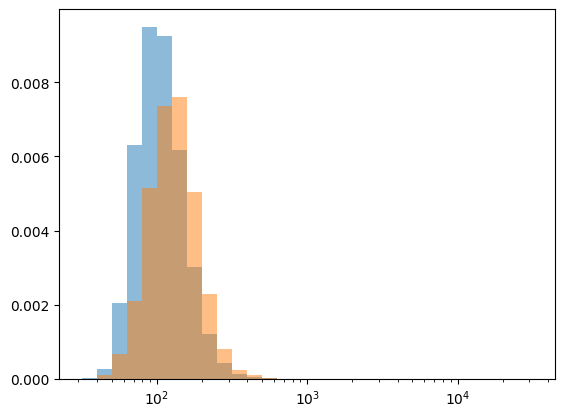

In [71]:
bins = np.logspace(1.5,4.5,31)
plt.hist(Crabdata["sumpf"],bins=bins,alpha=0.5,density=True)
plt.hist(Crabdata["sumpf"][(np.abs(Crabdata["cx"])>70)&(np.abs(Crabdata["cy"])>70)],bins=bins,alpha=0.5,density=True)
plt.xscale("log")
plt.show()

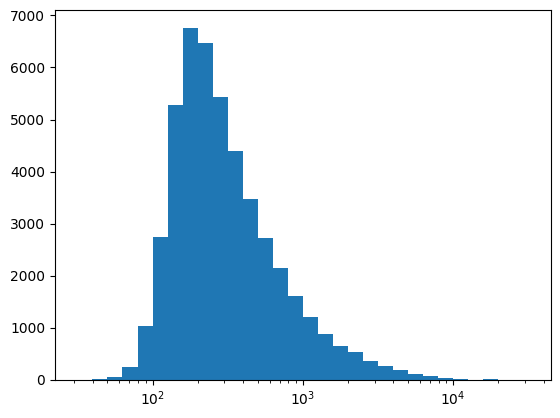

In [51]:
bins = np.logspace(1.5,4.5,31)
plt.xscale("log")
plt.show()

In [48]:
amax = np.zeros(3)
bmax = np.zeros(3)
lengthmax = np.zeros(3)
sigmax = np.zeros(3)
alist = list()
blist = list()
sigma10list = list()
sigma50list = list()
sigma100list = list()
for a in np.logspace(-5, -1, 41):
    for b in np.linspace(0, 4, 41):
        sig = np.zeros(3)
        for i, energymin in enumerate([10,50,100]):
            cuted = np.where(
                (
                    (Crabdata["summd"] < a * 1e-3 * Crabdata["sumpf"] ** b)
                    | (Crabdata["summd"] < 0.4)
                )
                & (Crabdata["energy"] > energymin)
            )
            sig[i] = LIMA(
                1 / 359,
                np.sum(Crabdata["isgamma"][cuted] == 1),
                np.sum(Crabdata["isgamma"][cuted] == 0),
            )
        getmaxab(sig, a, b, amax, bmax, sigmax)
        alist.append(a)
        blist.append(b)
        sigma10list.append(sig[0])
        sigma50list.append(sig[1])
        sigma100list.append(sig[2])
        # print(
        #     f"{a:.1f}",
        #     f"{b:.1f}",
        #     f"{sig[0]:.2f}",
        #     f"{sig[1]:.2f}",
        #     f"{sig[2]:.2f}",
        # )


In [49]:
alist = np.array(alist)
blist = np.array(blist)
sigma10list = np.array(sigma10list)
sigma50list = np.array(sigma50list)
sigma100list = np.array(sigma100list)

In [50]:
b,a = np.meshgrid(np.linspace(0, 4, 41),np.logspace(-5, -1, 41))

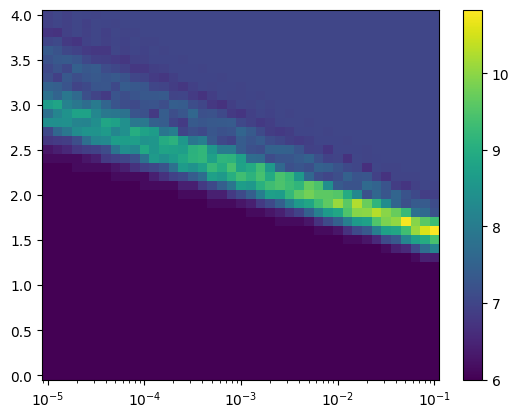

In [51]:
b,a = np.meshgrid(np.linspace(0, 4, 41),np.logspace(-5, -1, 41))
cs=plt.pcolormesh(a, b, sigma50list.reshape(a.shape))
plt.colorbar()
plt.xscale("log")
# plt.clabel(cs,inline=True)
plt.show()

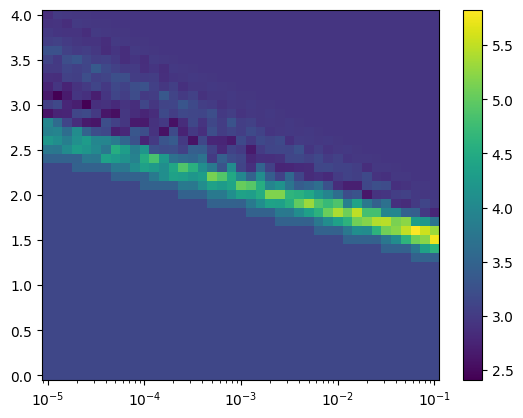

In [52]:
cs=plt.pcolormesh(a, b, sigma100list.reshape(a.shape))
plt.colorbar()
plt.xscale("log")
# plt.clabel(cs,inline=True)
plt.show()

In [13]:
amax

array([0.1, 0.1, 1.3])

In [14]:
bmax

array([1.7, 1.6, 1.1])

In [18]:
sigmax

array([17.92961166, 10.43344869,  5.39684029])

In [29]:
train_index,test_index = train_test_split(range(len(Crabdata["Ra"])),test_size=0.4,random_state=42)

In [30]:
label = "isgamma"

In [31]:
paraneed = {"isgamma","sumpf","summd","cx","cy"}

In [43]:
predictor=TabularPredictor(label=label,eval_metric="roc_auc").fit(pd.DataFrame(Crabdata)[paraneed].loc[train_index],num_cpus=30,num_gpus=2,presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20230513_111210/"
/tmp/ipykernel_24016/3996065789.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  predictor=TabularPredictor(label=label,eval_metric="roc_auc").fit(pd.DataFrame(Crabdata)[paraneed].loc[train_index],num_cpus=30,num_gpus=2,presets='best_quality')
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230513_111210/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.178-3 (2023-04-22)
Trai

KeyboardInterrupt: 

In [45]:
predictor=TabularPredictor.load("/home2/hky/github/Gamma_Energy/AutogluonModels/ag-20230513_111427")

In [46]:
predictor.feature_importance(pd.DataFrame(Crabdata)[paraneed].loc[test_index],subsample_size=int(5e5))

/tmp/ipykernel_24016/1845286512.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  predictor.feature_importance(pd.DataFrame(Crabdata)[paraneed].loc[test_index],subsample_size=int(5e5))
Computing feature importance via permutation shuffling for 4 features using 420062 rows with 5 shuffle sets...
	764.66s	= Expected runtime (152.93s per shuffle set)
	566.08s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
summd,0.038603,0.002620,0.000003,5,0.043998,0.033208
sumpf,0.022556,0.004969,0.000265,5,0.032788,0.012325
cx,0.003230,0.001850,0.008748,5,0.007040,-0.000580
cy,0.000091,0.003024,0.474787,5,0.006317,-0.006135


In [52]:
cx = np.linspace(-150,150,301)
cy = np.linspace(-150,150,301)
x,y=np.meshgrid(cx,cy)

In [57]:
x_=x.reshape(-1)
y_=y.reshape(-1)
theta_val = 30
summd_val = 3
sumpf_val = (summd_val/2.1e-3)**(1/1.2)
theta = np.full_like(x_,theta_val)
summd = np.full_like(x_,summd_val)
sumpf = np.full_like(x_,sumpf_val)

In [58]:
df = pd.DataFrame({"cx":x_,"cy":y_,"summd":summd,"sumpf":sumpf,"theta":theta})

In [59]:
df["isgamma"]=predictor.predict_proba(df)[1]

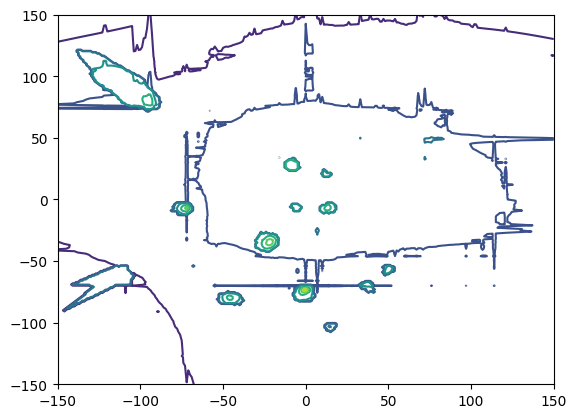

In [60]:
cs=plt.contour(x, y, df["isgamma"].to_numpy().reshape(x.shape))
# plt.clabel(cs,inline=True)
plt.show()


In [47]:
np.min(Crabdata["summd"][Crabdata["summd"]!=0])

0.4000480314960623

In [49]:
np.log10(35)

1.5440680443502757

In [11]:
summd = np.logspace(-0.4,4,100)
summd = np.concatenate([[0],summd])
sumpf = np.logspace(1.5,4,100)
x,y=np.meshgrid(sumpf,summd)

In [12]:
x_=x.reshape(-1)
y_=y.reshape(-1)

In [13]:
proba = predictor.predict_proba(pd.DataFrame({"summd":y_,"sumpf":x_}))[1].to_numpy()

In [23]:
predictor.predict_proba(pd.DataFrame({"summd":[0],"sumpf":[1000]}))

,0,1
0,0.864555,0.135445


(array([9.066e+03, 2.950e+02, 2.580e+02, 2.380e+02, 1.420e+02, 6.700e+01,
        2.500e+01, 6.000e+00, 2.000e+00, 1.000e+00]),
 array([0.00166858, 0.03696109, 0.0722536 , 0.10754611, 0.14283862,
        0.17813113, 0.21342365, 0.24871616, 0.28400867, 0.31930118,
        0.35459369]),
 <BarContainer object of 10 artists>)

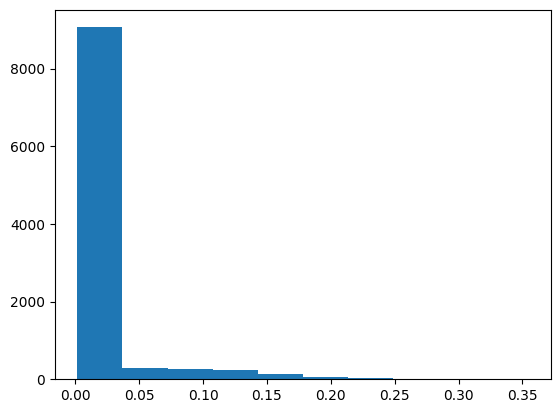

In [17]:
plt.hist(proba)

In [25]:
proba/=0.4

In [14]:
y[y==0] = 10**-0.8

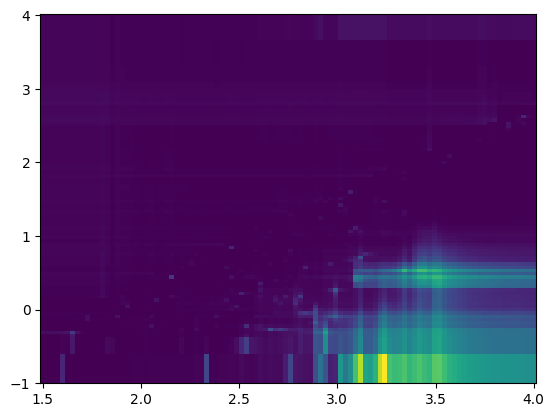

In [26]:
cs=plt.pcolormesh(np.log10(x), np.log10(y), proba.reshape(x.shape))
# plt.clabel(cs,inline=True)
plt.show()